#Machine learning



Dado que se está trabajando en un entorno en la nube, se procede a enlazar el cuaderno con el repositorio donde se encuentran alojados los datos que van a ser tratados en el problema

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se importan las librerías necesarias para poder realizar tanto el tratamiento de los datos, como el preprocesamiento de los mismos. Además, se importan las librerías necesarias para entrenar y evaluar los modelos con los cuales se va a tratar de solucionar el problema.

In [ ]:
from glob import glob
import numpy as np #se importa numpy para realizar el tratamiento de arrays numéricos

import os #librería usada para crear directorios dentro del sistema.
import sys
import pandas as pd #Librería usada para leer y escribir las bases de datos en formato .csv
from sklearn.preprocessing import StandardScaler #normalizador standard de sklearn
from sklearn.preprocessing import MinMaxScaler #normalizador alternativo de sklearn
from sklearn.decomposition import PCA #Herramienta para realizar análisis de componentes principales
import sklearn.neural_network as neural #herramienta para la creación de redes neuronales de sklearn

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


#import pyedflib as pyedf #librería necesaria para tratar datos .edf
import matplotlib.pyplot as ptl
from sklearn.utils import class_weight #herramienta de sklearn para determinar los pesos de cada clase en un problema desbalanceado

from keras.layers import Dense, Flatten, Conv1D,Dropout,MaxPooling1D #se importan las librerías necesarias para crear una red neuronal con capas convolucionales de 1d y capas de pooling

from sklearn.preprocessing import OneHotEncoder #Herramienta para realizar el one hot encoding de las etiquetas.
from keras.models import Sequential #Herramienta que permite la creación de redes neuronales repartidas en capas.

from keras.regularizers import l1 #Herramienta de keras para entrenar un modelo con regularizaciíon L1
from keras import optimizers #Optimizadores de Keras

Using TensorFlow backend.


#Tratamiento de los datos crudos

En esta sección se trata de crear la base de datos en formato .csv (descriptores y etiquetas)a partir de los datos de las señales que se encuentran en formato .edf.

Dado que el sistema final recibirá un segmento de 30 segundos de una señal cerebral, los datos de cada una de las señales, las cuales tienen duración variable, se dividirán en segmentos de 30 segundos de duración al que se asignará una etiqueta basandose en el estado de sueño predominante en esos 30 segundos. Es decir, el problema a tratar se transforma de esta manera en un problema multiclase con 1 sola etiqueta por dato.

In [ ]:
dataset="/content/drive/My Drive/parcial2/sleep-cassette"
archivos= sorted(glob(os.path.join(dataset, "*.edf"))) #se cargan los datos del dataset

El método generar etiquetas permite crear las eiquetas de n señales de duración 30 segundos basandose en el archivo de etiquetas creado para toda la duración de esa señal.

In [ ]:
def generar_etiquetas(archivo):
  st_FileHypEdf = pyedf.EdfReader(archivo) #se lee el archivo que contiene las etiquetas del problema
  v_HypTime, v_HypDur, v_Hyp = st_FileHypEdf.readAnnotations() #se determinan los arrays de tiempos de inicio de cada etiqueta, su tiempo de duración y su valor

  largo = sum(v_HypDur)/30 #se encuentra el número de etiquetas de salida
  tiempoResiduo = 0
  etiquetas = [] #array donde se van a almacenar las etiquetas creadas
  tiempoDuracion2 = 0
  for i in range(1,v_HypTime.shape[0]-2):
    etiquetaActual = v_Hyp[i] #se calcula la etiqueta actual para el segmento de tiempo en el que nos encontramos
    tiempoDuracion = v_HypDur[i] #duración de la etiqueta
    numeroEtiquetas = tiempoDuracion//30 #el número de etiquetas es la división entera del tiempo de duración (en segundos) y 30 segundos
    tiempoResiduo = tiempoDuracion%30 #el tiempo residuo se usa para calcular la siguiente etiqueta
    for j in range(int(numeroEtiquetas)): #se crean tantas etiquetas como las que fueron calculadas
      etiquetas.append(etiquetaActual)
    tiempoDuracion2 = tiempoDuracion2+numeroEtiquetas #se actualiza el tiempo de duración

  return etiquetas

Se usa el método creado anteriormente para calcular las etiquetas de cada uno de los archivos edf presentes en la base de datos cruda

In [ ]:
resultados= dict() #diccionario donde se van a almacenar las etiquetas de cada clase.
k=0 #indicador del número de archivo.
for i in range(0,212,2): #solo se exploran los archivos de etiquetas, se ignoran los archivos de la señal de sueño.
  resultados['resultado'+str(k)]=generar_etiquetas(archivos[i+1]) # se almacenan en un diccionario cada una de las etiquetas
  print(np.array(resultados['resultado'+str(k)]).shape) # se imprime el largo de cada uno de los diccionarios.
  k=k+1

(721,)
(1008,)
(983,)
(1066,)
(905,)
(890,)
(832,)
(791,)
(1116,)
(1084,)
(552,)
(1128,)
(723,)
(896,)
(856,)
(1153,)
(1014,)
(934,)
(1023,)
(1960,)
(985,)
(973,)
(809,)
(682,)
(1725,)
(857,)
(908,)
(884,)
(832,)
(836,)
(1647,)
(1029,)
(885,)
(883,)
(1657,)
(844,)
(800,)
(1415,)
(1159,)
(903,)
(901,)
(1463,)
(688,)
(979,)
(988,)
(787,)
(1614,)
(1555,)
(1655,)
(852,)
(901,)
(1477,)
(860,)
(932,)
(970,)
(1007,)
(950,)
(1011,)
(1488,)
(811,)
(734,)
(934,)
(1061,)
(1441,)
(901,)
(1769,)
(1194,)
(1381,)
(1462,)
(856,)
(845,)
(704,)
(798,)
(1389,)
(1656,)
(1751,)
(944,)
(952,)
(958,)
(804,)
(665,)
(764,)
(579,)
(842,)
(1075,)
(972,)
(1088,)
(1046,)
(864,)
(904,)
(1068,)
(2056,)
(1938,)
(1787,)
(981,)
(921,)
(1206,)
(983,)
(967,)
(834,)
(877,)
(976,)
(936,)
(1597,)
(1028,)
(927,)


Se concatenan los arrays creados con el fin de hacer un archivo general de etiquetas de cada uno de los archivos.

In [ ]:
final2=np.concatenate((np.array(resultados['resultado'+str(0)]), np.array(resultados['resultado'+str(1)])), axis=0)
for k in range(2,106):
  print(k)
  final2=np.concatenate((final2, np.array(resultados['resultado'+str(k)])), axis=0)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


Se crea un archivo final de etiquetas en el que se organizan en 4 clases correspondientes a las especificadas en la descripción del examen 2. De este modo se agrupan las etiquetas en los números 0,1,2,3 lo cual facilitará su tratamiento más adelante.

In [ ]:
for i in range(final2.shape[0]):
  if final2[i]=='Sleep stage W': #datos de la clase 0
    final2[i]=0
  elif final2[i]=='Sleep stage 1' or final2[i]=='Sleep stage 2': #datos de la clase 1
    final2[i]=1
  elif final2[i]=='Sleep stage 3' or final2[i]=='Sleep stage 4': #datos de la clase 2
    final2[i]=2
  elif final2[i]=='Sleep stage R': #datos de la clase 3
    final2[i]=3

Se almacena el array creado en un archivo .csv lo cual era el objetivo principal del proceso

In [ ]:
pd.DataFrame(final2).to_csv('/content/drive/My Drive/parcial2/y_train.csv')

El método guardar_señal permite dividir un archivo de datos edf de la señal del encefalograma en segmentos de 30 segundos a la velocidad de muestréo definida para dicha señal (0.01 muetras/s). esto implica que cada segmento de 30 segundos de señal contiene 3000 muestras.  

In [ ]:
def guardar_señal(archivo,etiqueta):
  st_FileHypEdf = pyedf.EdfReader(etiqueta)

  v_HypTime, v_HypDur, v_Hyp = st_FileHypEdf.readAnnotations() #se leen los datos de la señal



  st_FileEdf = pyedf.EdfReader(archivo)
  # Lectura de las señales s_SigNum señales con nombres v_Signal_Labels

  s_SigNum = st_FileEdf.signals_in_file
  #print(s_SigNum)
  v_Signal_Labels = st_FileEdf.getSignalLabels()


  # Conversion a segundos usando frecuencia de muestreo.
  s_SigRef = 0
  s_NSamples = st_FileEdf.getNSamples()[0]
  s_FsHz = st_FileEdf.getSampleFrequency(s_SigRef)
  print(s_NSamples)

  # v_Sig = np.zeros((s_NSamples, 1))
  v_Sig = st_FileEdf.readSignal(s_SigRef)
  v_Time = np.arange(0, s_NSamples) / s_FsHz

  señales=[] #array donde van a ser almacenados los segmentos de la señal
  señal=int(v_HypTime[1]*100)
  for i in range(int((v_HypTime[int(v_HypTime.shape[0]-1)]-v_HypDur[int(v_HypTime.shape[0]-2)]-v_HypDur[0])/30)):
    señales.append(v_Sig[señal:señal+3000]) #se almacena la señal cada 30 segundos en un array
    señal=señal+3000 #se actualiza el tiempo hasta el que se ha segmentado la señal
  return señales


A continuación se recorren todos los archivos de señales y se divide cada uno en los intervalos deseados

In [ ]:
resultados= dict() #diccionario creado para almacenar los segmentos de cada archivo de la base de datos
k=0 #contador de archivos
for i in range(0,212,2):
  resultados['resultado'+str(k)]=guardar_señal(archivos[i],archivos[i+1]) #se almacenan los segmentos para cada uno de los archivos
  print(np.array(resultados['resultado'+str(k)]).shape)
  k=k+1

7950000
(721, 3000)
8490000
(1008, 3000)
8406000
(983, 3000)
8550000
(1066, 3000)
8412000
(905, 3000)
8268000
(890, 3000)
8460000
(832, 3000)
8196000
(791, 3000)
7710000
(1116, 3000)
8376000
(1084, 3000)
8166000
(552, 3000)
8418000
(1128, 3000)
8310000
(723, 3000)
8490000
(896, 3000)
8430000
(856, 3000)
8310000
(1153, 3000)
8388000
(1014, 3000)
7902000
(934, 3000)
8196000
(1023, 3000)
8574000
(1960, 3000)
8160000
(985, 3000)
8574000
(973, 3000)
7926000
(809, 3000)
8340000
(682, 3000)
8358000
(1725, 3000)
7818000
(857, 3000)
8442000
(908, 3000)
8268000
(884, 3000)
8322000
(832, 3000)
7860000
(836, 3000)
8592000
(1647, 3000)
7878000
(1029, 3000)
8256000
(885, 3000)
8226000
(883, 3000)
8172000
(1657, 3000)
8268000
(844, 3000)
8526000
(800, 3000)
8322000
(1415, 3000)
7830000
(1159, 3000)
8412000
(903, 3000)
8010000
(901, 3000)
8430000
(1463, 3000)
8082000
(688, 3000)
8100000
(979, 3000)
8280000
(988, 3000)
8238000
(787, 3000)
7920000
(1614, 3000)
8106000
(1555, 3000)
8130000
(1655, 3000)
8

Se concatenan todos los diccionarios creados para cada archivo, esto con el fin de hacer un solo archivo con toda la información de las señales que coincida con el archivo creado para las etiquetas. De este modo, se tienen 2 archivos con los cuales se pueden realizar comodamente las tareas de machine learning

In [ ]:
final=[]
final2=np.concatenate((np.array(resultados['resultado'+str(0)]), np.array(resultados['resultado'+str(1)])), axis=0)
for k in range(2,106):
  print(k)
  final2=np.concatenate((final2, np.array(resultados['resultado'+str(k)])), axis=0)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


Por último se guarda la información del arary en un archivo csv para poder usarla en cualquier momento del proceso de diseño sin tener que realizar todo el proceso descrito anteriormente.

In [ ]:
df = pd.DataFrame(final2) #se transforma el array en un dataframe de pandas

In [ ]:
df.to_csv('/content/drive/My Drive/parcial2/X1.csv') #se almacena el array en una dirección de memoria específica

#LECTURA DE LA BASE DE DATOS:

En primer lugar, se debe realizar la lectura de la base de datos. Para esto se usa la librería panda. Se realiza la conversión del txt a csv sin tener en cuenta la cabecera ya que la base de datos no tiene nombres de las características.

In [ ]:
import pandas as pd
df = pd.read_csv ("/content/drive/My Drive/parcial2/X.csv",header=0) #se importan los datos de las señales

In [ ]:
df= df.drop('Unnamed: 0', 1) #se elimina la columna de indice producto del preprocesamiento

In [ ]:
df2=pd.read_csv ("/content/drive/My Drive/parcial2/y_train.csv",header=0) #se importan las etiquetas para cada uno de los datos

In [ ]:
df2= df2.drop('Unnamed: 0', 1) #se elimina la columna de indice producto del preprocesamiento

# Pre-procesamiento

Se realiza el pre-procesamiento de los datos con el fin de eliminar características y ajustar los datos para el entrenamiento.

##Normalizar:
Para la normalización estandar de los datos, la cual fue usada en todo el desarrollo se tiene:

*   Normalizado=(x-media)/(varianza)

De esta forma se tienen los datos con media 0 y desviación estandar de 1. Esto evitara que existan datos que sean muy grandes comparados con los otros (datos atipicos) que desajusten el modelo e impidan un correcto ajuste de los parámetros a construir. \

Este proceso se realizó con la herramienta standardScaler de sklearn la cual ejecuta esta acción automáticamente. Cabe aclarar que también se probó con un normalizador alternativo, el MinMaxScaler, pero este no brindo tan buenos resultados como el normalizador standard, por lo que se eligió este último para realizar todos los procedimientos.


In [ ]:
#normalización entrada:
x_train=df.values  # se convierte los datos a un array de numpy

#normalizar
normalizar= StandardScaler() #se crea el modelo normalizador de sklearn
normalizar.fit(x_train) #se ajustan los parámetros de ese modelo con los datos del dataset
x_train=normalizar.transform(x_train) #se normalizan los datos
y_train=df2.values #se convierten las etiquetas a un array de numpy
y_train.shape #se revisa el largo de las etiquetas

(112652, 1)

##Análisis de componentes principales:

Dado que de antemano no se conocen los descriptores a usar en la señal de entrada y con el fin de reducir la dimensionalidad de los datos se usa análisis de componentes principales(PCA). Esto permite eliminar variables redundantes, lo cual ayudara a prevenir el overfitting y reducir el tiempo de entrenamiento.  

PCA tiene como objetivo describir un conjunto de datos en términos de nuevas variables no correlacionadas.Entonces, esta técnica busca proyectar los datos en n vectores que sean ortonormales y maximicen la varianza. En este caso se quiere reducir en gran medidad el número de variables ya que los procesos de diseño pueden tomar mucho tiempo con datos redudantes.

En este caso se usó una varianza entre datos del 95% esto quiere decir que solo se acepten datos que varíen entre si por lo menos esta cantidad. Este valor fue elegído en el proceso de diseño luego de probar varios valores para este parámetro (0.6, 0.8, 0.9, 0.95) y encontrar que la precisión del modelo se maximiza con valores altos de varianza, tales como el usado en este caso.

In [ ]:
#Análisis de componentes principales
pca=PCA(.95) #se crea el modelo de pca usando la herramienta de sklearn
pca.fit(x_train) #se ajusta el modelo usando los datos del dataset
x_train=pca.transform(x_train) #se actualizan las variables del modelo para reducir la dimensionalidad

Después de aplicar PCA se redujo la dimensionalidad a 885. Esto indica que se redujeron aproximadamente el 70% de las variables iniciales con lo que se puede reducir en gran medida los tiempos de procesamiento.

In [ ]:
x_train.shape #número de filas del array de características

(112652, 885)

Dado que al momento de crear la base de datos no se notó el hecho de que existian 2 etiquetas que no tenían sentido para el problema, tal cual y como se planteó, estas etiquetas son: 'Movement time' y 'Sleep stage ?' por lo que en las siguientes celdas se va a tratar de eliminar los datos correspondientes a estas etiquetas.

In [ ]:
#ajustar datos
x=np.ones((111752, 885))+10 #se crea el array donde se van a almacenar las características corregidas del problema
y=np.ones((111752, 1))+10 #se crea el array donde se van a almacenar las etiquetas corregidas.




In [ ]:
j=0
for n in range(y_train.shape[0]): #se recorre todo el array de etiquetas
  if y_train[n]!='Movement time' and y_train[n]!='Sleep stage ?':
    #se almacenan si estas son diferentes de las etiquetas desconocidas
    y[j]=y_train[n] #se actualiza el array de etiquetas
    x[j]=x_train[n] #se actualiza el array de descriptores
    j=j+1


# Estimativo:

A continuación se dividen los datos en set de entrenamiento, validación y test. En este caso se usa la convención usual para elegír que porcentaje de datos corresponden a cada set, es decir, se deja un 10% de los datos para validación, 10% para test y 80% para entrenamiento.

En este caso se tienen 111752 datos por lo cual se separan 89402 para entrenamiento, 11176 para validación y 11176 datos para test.

In [ ]:
X=x[0:89402]  #datos de entrenamiento

Y=y[0:89402]  #datos de entrenamiento

X_val=x[89402:100572]  #datos de validación

Y_val=y[89402:100572]  #datos de validación

X_test=x[100572:111752]  #datos de prueba

Y_test=y[100572:111752]  #datos de prueba

El número de datos para cada clase del problema es:

clase 0: 22,820\
clase 1: 60,028\
clase 2: 10,623\
clase 3: 18,281

por lo que se nota que no se está trabajando con un problema balanceado y es necesario trabajar este con los desbalances presentes. Para esto se usa la herramienta de sklearn class_weight y se calculan los pesos que debe tener cada clase para que se pueda entrenar el modelo adecuadamente


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y.ravel()),
                                                 y.ravel()) #se calculan los pesos usando el archivo de etiquetas

In [ ]:
class_weights #pesos de cada clase arrojados en el paso anterior

array([1.22427695, 0.46541614, 2.62995387, 1.52825338])

#Encontrar el modelo

Con el fin de resolver el problema, se trató de crear diferentes tipos de modelos de aprendizaje, tanto en el campo del aprendizaje balanceado como en el del no balanceado. De esta forma, en el campo balanceado se trataron de entrenar 3 tipos de modelos: Suport vector machines (SVM), Adaboost y redes neuronales. Los SVM supusieron resultados aceptables con tiempos de entrenamiento demasiado altos, lo que volvía casi imposible realizar una sintonización de los parámetros de aprendizaje de este en el plazo de trabajo que se tuvo a disposición,  por lo que se terminó descartando esta solución. En sentido contrario, Adaboost supuso tiempos de entrenamiento bajos con errores altos, sin importar la sintonización de sus parámetros, por lo que fue descartada inmediatamente. Por último, las redes neuronales fueron el candidato más fuerte y permitieron obtener precisiones más altas que los métodos anteriores con tiempos de entrenamiento aceptables. Por esta razón, se evaluaron varios modelos y se llegó a resultados insuficientes, aunque mejores que el azar, por lo que se terminó descartando la solución balanceada para este problema.

Una aproximación diferente al problema, antes de pasar al campo desbalanceado, fue realizar una arquitectura onevsall con redes neuronales, donde la primera clase a descartar era la clase más numerosa, en este caso aproximadamente 6 veces más numerosa que cualquier otra clase. A partir de este punto, el problema se trataba como un problema balanceado de solo 3 clases y se entrenaba basandose en los datos de solo estas 3 clases. Sin embargo, el resultado no fue mejor que el encontrado usando redes neuronales convencionales por lo que se terminó por descartar también esta solución.

Por último, Se realizó una aproximación por aprendizaje no balanceado, añadiendo pesos a cada una de las clases y entrenando redes neuronales convencionales. Los resultados en este caso fueron mucho mejores que los encontrados hasta ese momento, con tiempos de entrenamiento bajos y errores igualmente bajos, por lo que se decidió elegir este modelo para solucionar el problema.

A continuación se pasó a revisar diferentes aproximaciones al problema usando diferentes tipos de redes neuronales, encontrando que las redes neuronales conconvolucionales mejoraban la precisión del modelo mejor que otros tipos de redes. Despúes de realizar muchos ensayos con diferentes parámetros de las redes como son learning rate, regularización, funciones de activación y funciones de perdidas, se encontró un resultado que se cree suficiente para este problema.

#SVM

In [ ]:
svc = svm.SVC(C=30, kernel = 'rbf', verbose = False, gamma = 1/4) #se compila el SVM para un valor de C específico.
svc.fit(X, Y) #se entrena el modelo con los datos de entrenamientos creados anteriormente.
C=svc.score(X_val,Y_val) #se almacena en el array el valor resultante de validar el modelo en los datos de validación.

#AdaBoost

AdaBoost con arboles de decisión permite crear diferentes clasificadores que tratan de corregir al anterior. Es importante elegir la profundidad del arbol y el numero de estimadores que se usaran con el fin de encontrar la mejor accuracy posible.

In [ ]:
profundidad=[1,2,3] #Profundidad
estimadores=[50,100,150,200,250,300,350,400,450,500] #cantidad de estimadores

In [ ]:
models= dict() #diccionario para guardar cada modelo
accuracys= np.ones(30)#creacion array de unos para guardar el accuracy
graficax= np.ones(30)#creacion array de unos para guardar el numero de stimadores
graficay=np.ones(30)#creacion array de unos para guardar la progundidad
j=0
for i in estimadores:
  for k in profundidad:
    models['model'+str(i)+'_'+str(k)] = AdaBoostClassifier(DecisionTreeClassifier(max_depth=k),
                         algorithm="SAMME",
                         n_estimators=i)#crear modelos
    models['model'+str(i)+'_'+str(k)].fit(X, Y.ravel())#entrenar modelos
    accuracys[j] =models['model'+str(i)+'_'+str(k)].score(X_val, Y_val)#evaluar
    graficax[j]=i
    graficay[j]=k
    j=j+1

In [ ]:
#encontrar el modelo con el mejor accuracy
value2=np.max(accuracys)
i2= np.where(accuracys == value2)

maximo_x=graficax[i2[0][0]]

maximo_y=graficay[i2[0][0]]
print("Mejor modelo en los datos de test ,usando "+str(int(maximo_x))+" como numero de estimadores y "+str(int(maximo_y))+" como profundidad, con un valor  de:"+str(value2))

Mejor modelo en los datos de test ,usando 300 como numero de estimadores y 2 como profundidad, con un valor  de:51.81021214


##one hot encoding
Como convención para realizar el entrenamiento de un modelo, basado en redes neuronales, se usa el "one hot encoding" para codificar las etiquetas de salida. Esto significa que a la salida de la red neuronal a usar se tienen tantas neuronas como clases del problema. Esto significa que cada neurona corresponde a una clase y la salida en dicha neurona solo es 1 cuando los datos correspondan a dicha clase y 0 en caso contrario.

In [ ]:
ohe = OneHotEncoder() #se declara el modelo de one hot encoding de sklearn
Y = ohe.fit_transform(Y).toarray() #se ajustan las etiquetas de entrenamiento a la nueva codificación.
Y_val = ohe.fit_transform(Y_val).toarray() #se ajustan las etiquetas de validación a la nueva codificación.
Y_test = ohe.fit_transform(Y_test).toarray() #se ajustan las etiquetas de test a la nueva codificación

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

#Redes neuronales - problema  balanceado

In [ ]:
modelo = neural.MLPClassifier(solver='adam',activation='relu',hidden_layer_sizes=(900,450,200),alpha=0.1,max_iter=200,verbose=True,momentum=0.5)
modelo.fit(X2,Y2)
accuracy=modelo.score(X_val2,Y_val2)
print(accuracy,modelo.score(X_test2,Y_test2))

Iteration 1, loss = 1.61208333
Iteration 2, loss = 1.21042051
Iteration 3, loss = 1.02789277
Iteration 4, loss = 0.89275747
Iteration 5, loss = 0.72097103
Iteration 6, loss = 0.58817801
Iteration 7, loss = 0.52597861
Iteration 8, loss = 0.46970627
Iteration 9, loss = 0.46521833
Iteration 10, loss = 0.44173871
Iteration 11, loss = 0.43324509
Iteration 12, loss = 0.42202867
Iteration 13, loss = 0.42100711
Iteration 14, loss = 0.41258163
Iteration 15, loss = 0.41124714


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.6789168278529981 0.5516041747197526


A partir de estos resultados se sabe que por la propagación de errores, el resultado de realizar un clasificador como el planteado va a ser insuficiente para el problema. Por esta razón, se descarta esta idea y se prueba solucionar este problema como un problema desbalanceado.

#Redes neuronales

Se utilizan redes neuronales para resolver el problema, se piensa en primer lugar en una red con dos capas escondidas. Se varia el número de neuronas de cada una de estas y se encuentra el modelo con mejor accuracy. En total se entrenan 50 modelos.

In [ ]:
#cantidad de neuronas
capa2=[100,200,300,400,500] #Profundidad
capa1=[100,200,300,400,500,600,700,800,900,1000] #cantidad de estimadores

In [ ]:
#con 2 capas
models= dict() #diccionario para guardar cada modelo
accuracys= np.ones(50)#creacion array de unos para guardar el accuracy
graficax= np.ones(50)#creacion array de unos para guardar el numero de stimadores
graficay=np.ones(50)#creacion array de unos para guardar la progundidad
modelo=np.ones(50)
j=0
for i in capa1:
  for k in capa2:
    models['model'+str(i)+'_'+str(k)]= Sequential()
    models['model'+str(i)+'_'+str(k)].add(Dense(i, input_dim=885, activation='relu'))
    models['model'+str(i)+'_'+str(k)].add(Dense(k, activation='relu'))
    models['model'+str(i)+'_'+str(k)].add(Dense(4, activation='softmax'))
    adam =optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad= True) #Inicializar optimizador:Adam
    models['model'+str(i)+'_'+str(k)].compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc', 'mse']) # Compilar modelo
    models['model'+str(i)+'_'+str(k)].fit(x=X, y=Y, epochs=15,class_weight=class_weights,validation_data=(X_val, Y_val))
    datos = models['model'+str(i)+'_'+str(k)].evaluate(X_val, Y_val, verbose=0)
    accuracys[j] =datos[1]*100
    graficax[j]=i
    graficay[j]=k
    j=j+1


In [ ]:
#encontrar el modelo con el mejor accuracy
value2=np.max(accuracys)
i2= np.where(accuracys == value2)

maximo_x=graficax[i2[0][0]]

maximo_y=graficay[i2[0][0]]
print("Mejor modelo en los datos de validación ,usando "+str(int(maximo_x))+" neuronas en la primera capa y "+str(int(maximo_y))+" neuronas en la segunda capa, con un valor  de:"+str(value2))

Mejor modelo en los datos de validación ,usando 400 neuronas en la primera capa y 100 neuronas en la segunda capa, con un valor  de:55.65801253357206


El mejor modelo fue aquel con 400 neuronas en la primera capa y 100 neuronas en la seguna

#Red neuronal Convolucional
Se resuelve el problema de clasificación usando una red neuronal, en especifico se realiza una red convolucional. Entonces, las capas convolucionales que se usan son en una dimensión. Estas capas son utiles para que las redes neuronales aprendan caracteristicas secuencias de observaciones. Luego, pueden ser de utilidad en este caso al contar con diferentes secuencias de observaciones obtenidas mediante sensores.

Cabe mencionar, que el comportamiento de la convolución en una dimensión es similar al de dos dimensiones. Luego, la diferencia radica en como cada uno los filtros  recorre la entrada y por supuesto la dimesionalidad de la entrada. En la convolución 1D cada una de las ventanas deslizantes(filtros) recorre la matriz de entrada de arriba hacia abajo, esto se realiza para cada uno de los datos de entrenamiento. Finalmete, cada uno de estos se suman y el resultado es pasado por la función de activación. Esto se repite para el número de filtros desaeados.

En primera instancia, se piensa en una red con dos capas covolucionales junto con una capa pooling como es tipico al usar capas convolucionales. Ademas, se agrega Dropout que permite que ciertas neuronas no se actualicen durante una época. Se varia el número de filtros con el fin de encontrar el más adecuado.

In [ ]:
#se ajustan los datos para ser correctamente utilizados en la convolución 1D
X = X.reshape(89402, 885,1) #Reajuste de datos  entrenamiento
X_val = X_val.reshape(11170, 885,1)#Reajuste de datos validación
X_test = X_test.reshape(11180, 885,1)#Reajuste de datos test

In [ ]:
capa2=[2,4,8,16,32] #Profundidad
capa1=[2,4,8,16,32] #cantidad de estimadores

In [ ]:
#con 2 capas
models= dict() #diccionario para guardar cada modelo
accuracys= np.ones(25)#creacion array de unos para guardar el accuracy
graficax= np.ones(25)#creacion array de unos para guardar el numero de stimadores
graficay=np.ones(25)#creacion array de unos para guardar la progundidad
modelo=dict()
j=0
for i in capa1:
  for k in capa2:
    models['model'+str(i)+'_'+str(k)] = Sequential() #Inicialización del modelo
    models['model'+str(i)+'_'+str(k)].add(Conv1D(filters=i, kernel_size=3, activation='relu', input_shape=(885,1)))# Capa convolucional con 32 filtros y tamaño del kernel 3
    models['model'+str(i)+'_'+str(k)].add(Conv1D(filters=k, kernel_size=3, activation='relu'))# Capa convolucional con 32 filtros y tamaño del kernel 3
    models['model'+str(i)+'_'+str(k)].add(Dropout(0.5)) #Dropout de 50%
    models['model'+str(i)+'_'+str(k)].add(MaxPooling1D(pool_size=2)) # Capa poolig de tamaño 2
    models['model'+str(i)+'_'+str(k)].add(Flatten()) # Capa Flatten
    #parte totalmente conectada



    models['model'+str(i)+'_'+str(k)].add(Dense(4, activation='softmax'))
    adam =optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad= True) #Inicializar optimizador:Adam
    models['model'+str(i)+'_'+str(k)].compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc', 'mse']) # Compilar modelo
    modelo['modelo'+str(i)+'_'+str(k)]=models['model'+str(i)+'_'+str(k)].fit(x=X, y=Y, epochs=25,class_weight=class_weights,validation_data=(X_val, Y_val))
    datos = models['model'+str(i)+'_'+str(k)].evaluate(X_val, Y_val, verbose=0)
    accuracys[j] =datos[1]*100
    graficax[j]=i
    graficay[j]=k
    j=j+1


Train on 89402 samples, validate on 11170 samples
Epoch 1/25
89402/89402 [==============================] - 13s 140us/step - loss: 1.7097 - acc: 0.3964 - mean_squared_error: 0.2015 - val_loss: 1.4960 - val_acc: 0.3953 - val_mean_squared_error: 0.1965
Epoch 2/25
89402/89402 [==============================] - 12s 136us/step - loss: 1.5062 - acc: 0.4353 - mean_squared_error: 0.1879 - val_loss: 1.3924 - val_acc: 0.4217 - val_mean_squared_error: 0.1879
Epoch 3/25
89402/89402 [==============================] - 12s 140us/step - loss: 1.3843 - acc: 0.4632 - mean_squared_error: 0.1787 - val_loss: 1.3204 - val_acc: 0.4478 - val_mean_squared_error: 0.1811
Epoch 4/25
89402/89402 [==============================] - 13s 143us/step - loss: 1.3046 - acc: 0.4867 - mean_squared_error: 0.1716 - val_loss: 1.2618 - val_acc: 0.4694 - val_mean_squared_error: 0.1750
Epoch 5/25
89402/89402 [==============================] - 13s 141us/step - loss: 1.2416 - acc: 0.5055 - mean_squared_error: 0.1657 - val_loss: 1.2

IndexError: ignored

In [ ]:
#encontrar el modelo con el mejor accuracy
value2=np.max(accuracys)
i2= np.where(accuracys == value2)

maximo_x=graficax[i2[0][0]]

maximo_y=graficay[i2[0][0]]
print("Mejor modelo en los datos de validación ,usando "+str(int(maximo_x))+" filtros en la primera capa y "+str(int(maximo_y))+" filtros en la segunda capa, con un valor  de:"+str(value2))

Mejor modelo en los datos de validación ,usando 4 filtros en la primera capa y 32 filtros en la segunda capa, con un valor  de:68.39749328558639


Se evidencia una mejora significativa con recpecto a todos los otros metodos desarrollados, por esta razón se decide mejorar este tipo de red para alcanzar el maximo accuracy.

Luego, se agregan dos capas totalmente conectadas. Dado la experiencia y la literatura tratada en el curso de machine se piensa que esto puede mejorar el comportamiento de la red. Se encuentra el número de nueronas adecuado.

In [ ]:
capa2=[100,200,300,400,500] #Profundidad
capa1=[100,200,300,400,500,600,700,800,900,1000] #cantidad de estimadores

In [ ]:
#con 2 capas
models= dict() #diccionario para guardar cada modelo
accuracys= np.ones(50)#creacion array de unos para guardar el accuracy
graficax= np.ones(50)#creacion array de unos para guardar el numero de stimadores
graficay=np.ones(50)#creacion array de unos para guardar la progundidad
modelo=dict()
j=0
for i in capa1:
  for k in capa2:
    models['model'+str(i)+'_'+str(k)] = Sequential() #Inicialización del modelo
    models['model'+str(i)+'_'+str(k)].add(Conv1D(filters=4, kernel_size=3, activation='relu', input_shape=(885,1)))# Capa convolucional con 32 filtros y tamaño del kernel 3
    models['model'+str(i)+'_'+str(k)].add(Conv1D(filters=32, kernel_size=3, activation='relu'))# Capa convolucional con 32 filtros y tamaño del kernel 3
    models['model'+str(i)+'_'+str(k)].add(Dropout(0.5)) #Dropout de 50%
    models['model'+str(i)+'_'+str(k)].add(MaxPooling1D(pool_size=2)) # Capa poolig de tamaño 2
    models['model'+str(i)+'_'+str(k)].add(Flatten()) # Capa Flatten
    #parte totalmente conectada
    models['model'+str(i)+'_'+str(k)].add(Dense(i, activation='relu')) # Capa con 1000 neuronas
    models['model'+str(i)+'_'+str(k)].add(Dense(k, activation='relu'))  #


    models['model'+str(i)+'_'+str(k)].add(Dense(4, activation='softmax'))
    adam =optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad= True) #Inicializar optimizador:Adam
    models['model'+str(i)+'_'+str(k)].compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc', 'mse']) # Compilar modelo
    modelo['modelo'+str(i)+'_'+str(k)]=models['model'+str(i)+'_'+str(k)].fit(x=X, y=Y, epochs=15,class_weight=class_weights,validation_data=(X_val, Y_val))
    datos = models['model'+str(i)+'_'+str(k)].evaluate(X_val, Y_val, verbose=0)
    accuracys[j] =datos[1]*100
    graficax[j]=i
    graficay[j]=k
    j=j+1


In [ ]:
#encontrar el modelo con el mejor accuracy
value2=np.max(accuracys)
i2= np.where(accuracys == value2)

maximo_x=graficax[i2[0][0]]

maximo_y=graficay[i2[0][0]]
print("Mejor modelo en los datos de validación ,usando "+str(int(maximo_x))+" neuronas en la primera capa y "+str(int(maximo_y))+" neuronas en la segunda capa, con un valor  de:"+str(value2))

Mejor modelo en los datos de validación ,usando 1000 neuronas en la primera capa y 500 neuronas en la segunda capa, con un valor  de:69.21217547000896


Se oberva que el accuracy en los datos de validación mejoro, por lo tanto se dejan esta dos capas totalmente conectadas.

Después, se agrega regularización l1 a la parte totalmente conectada de la red:

In [ ]:
#con 2 capas
models= dict() #diccionario para guardar cada modelo
accuracys= np.ones(9)#creacion array de unos para guardar el accuracy
graficax= np.ones(9)#creacion array de unos para guardar el numero de stimadores

modelo=dict()
j=0
for i in range(1,10):
    models['model'+str(i)] = Sequential() #Inicialización del modelo
    models['model'+str(i)].add(Conv1D(filters=4, kernel_size=3, activation='relu', input_shape=(885,1)))# Capa convolucional con 32 filtros y tamaño del kernel 3
    models['model'+str(i)].add(Conv1D(filters=32, kernel_size=3, activation='relu'))# Capa convolucional con 32 filtros y tamaño del kernel 3
    models['model'+str(i)].add(Dropout(0.5)) #Dropout de 50%
    models['model'+str(i)].add(MaxPooling1D(pool_size=2)) # Capa poolig de tamaño 2
    models['model'+str(i)].add(Flatten()) # Capa Flatten
    #parte totalmente conectada
    models['model'+str(i)].add(Dense(1000, activation='relu',activity_regularizer=l1(i*0.0003))) # Capa con 1000 neuronas
    models['model'+str(i)].add(Dense(500, activation='relu',activity_regularizer=l1(i*0.0003)))  #


    models['model'+str(i)].add(Dense(4, activation='softmax',activity_regularizer=l1(i*0.0001)))
    adam =optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad= True) #Inicializar optimizador:Adam
    models['model'+str(i)].compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc', 'mse']) # Compilar modelo
    modelo['modelo'+str(i)]=models['model'+str(i)].fit(x=X, y=Y, epochs=15,class_weight=class_weights,validation_data=(X_val, Y_val))
    datos = models['model'+str(i)].evaluate(X_val, Y_val, verbose=0)
    accuracys[j] =datos[1]*100
    graficax[j]=i
    j=j+1

In [ ]:
#encontrar el modelo con el mejor accuracy
value2=np.max(accuracys)
i2= np.where(accuracys == value2)

maximo_x=graficax[i2[0][0]]

print("Mejor modelo en los datos de validación ,usando "+str(float(maximo_x*0.0001))+" como parametro de regularización, con un valor  de:"+str(value2))

Mejor modelo en los datos de validación ,usando 0.0003 como parametro de regularización, con un valor  de:69.91279034219922


Se obtuvo que el parametro se regularización adecuado es 0.0003 en la parte totalmente conectada. Se deja este modelo como el final.

Adiconal, se menciona que se probaron diferentes optimizadores con varias tasas de aprendizaje pero ninguno supero a lo obtenido con ADAM.

Se vuelve a entrenar el modelo final con el fin de evaluar su comportamiento:

In [ ]:
model = Sequential() #Inicialización del modelo
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(885,1)))# Capa convolucional con 32 filtros y tamaño del kernel 3
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))# Capa convolucional con 32 filtros y tamaño del kernel 3
model.add(Dropout(0.5)) #Dropout de 50%
model.add(MaxPooling1D(pool_size=2)) # Capa poolig de tamaño 2
model.add(Flatten()) # Capa Flatten
#parte totalmente conectada
model.add(Dense(1000, activation='relu',activity_regularizer=l1(0.0003))) # Capa con 1000 neuronas
model.add(Dense(500, activation='relu',activity_regularizer=l1(0.0003)))  #
model.add(Dense(4, activation='softmax',activity_regularizer=l1(0.0003))) #Capa de salida con función de activació


adam =optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad= True) #Inicializar optimizador:Adam
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc', 'mse']) # Compilar modelo

##modelo construido

El modelo final tiene la siguiente estructura:



1.  Capa convolucional 1D: 32 filtros, tamaño del kernel=3, función de activación Relu
2. Capa convolucional 1D: 32 filtros, tamaño del kernel=3, función de activación Relu
3. Capa Dropout: 50%, aleatoriamente se seleccionan neuronas que no se tendran en cuenta en cada capa.
4. Capa Pooling 1D con tamaño 2: Se utiliza para reducir la dimesionalidad de los datos y mejorar los tiempos de entrenamiento.
5. Capa Flatten: Se ajustan los datos a un solo vector para su correcto funcionamiento en la capa totalmente conectada.
6. Capa totalmente conectada: 1000 neuronas, función de activación Relu y regularización l1 de 0.0003
7. Capa totalmente conectada: 500 neuronas, función de activación Relu y regularización l1 de 0.0003
8. Capa totalmente conectada: 4 neuronas, función de activación softmax y regularización l1 de 0.0003



In [ ]:
model.summary() #resumen del modelo

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 883, 32)           128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 881, 32)           3104      
_________________________________________________________________
dropout_9 (Dropout)          (None, 881, 32)           0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 440, 32)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 1000)              14081000  
_________________________________________________________________
dense_26 (Dense)             (None, 500)              

In [ ]:
modelo=model.fit(x=X, y=Y, epochs=30,class_weight=class_weights,validation_data=(X_val, Y_val))

Train on 89402 samples, validate on 11170 samples
Epoch 1/30
89402/89402 [==============================] - 33s 371us/step - loss: 1.3745 - acc: 0.5371 - mean_squared_error: 0.1714 - val_loss: 1.3637 - val_acc: 0.4479 - val_mean_squared_error: 0.1753
Epoch 2/30
89402/89402 [==============================] - 31s 351us/step - loss: 1.2401 - acc: 0.5373 - mean_squared_error: 0.1539 - val_loss: 1.3271 - val_acc: 0.4479 - val_mean_squared_error: 0.1723
Epoch 3/30
89402/89402 [==============================] - 31s 350us/step - loss: 1.2076 - acc: 0.5377 - mean_squared_error: 0.1505 - val_loss: 1.3005 - val_acc: 0.4485 - val_mean_squared_error: 0.1696
Epoch 4/30
89402/89402 [==============================] - 31s 351us/step - loss: 1.1544 - acc: 0.5848 - mean_squared_error: 0.1423 - val_loss: 1.2449 - val_acc: 0.4916 - val_mean_squared_error: 0.1606
Epoch 5/30
89402/89402 [==============================] - 31s 350us/step - loss: 1.1133 - acc: 0.5934 - mean_squared_error: 0.1372 - val_loss: 1.2

Se evidencia que el modelo es entranado adecuadamente:

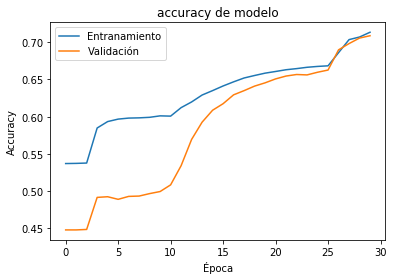

In [ ]:
import matplotlib.pyplot as plt
plt.plot(modelo.history['acc'])
plt.plot(modelo.history['val_acc'])
plt.title('accuracy de modelo')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend(['Entranamiento', 'Validación'], loc='upper left')
plt.show()

El accuracy en los datos de validación es 70.88%.

Finalmente, se evaluca el modelo en los datos de test:

In [ ]:
datos = model.evaluate(X_test, Y_test, verbose=0)
print("accuracy en los datos de test: "+ str(datos[1]*100))

accuracy en los datos de test: 68.82826475636477
